In [47]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

# 2. Least Square Line Fitting

## Visualize the data distribution

In [48]:
mat = loadmat("data_f_LSLF.mat")
data = mat['pts']
data = np.array(data)
data.shape

(2, 200)

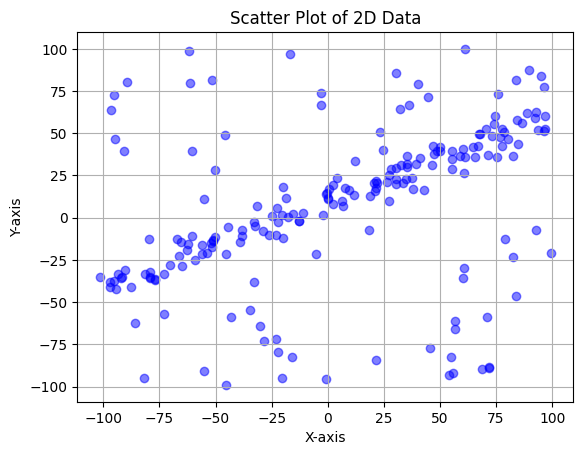

In [49]:
plt.scatter(data[0], data[1], c='blue', alpha=0.5)  # 'c' is the color, 'alpha' is transparency
plt.title('Scatter Plot of 2D Data')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.show()

## Calculate the covariance matrix of the data and find its eigenvalues and eigenvectors. 

In [50]:
covariance = np.cov(data)
covariance

array([[3418.29090234, 1039.75748627],
       [1039.75748627, 2177.72593476]])

In [51]:
eigenvalues, eigenvectors = np.linalg.eig(covariance)

In [52]:
eigenvalues

array([4008.72968704, 1587.28715007])

In [53]:
eigenvectors

array([[ 0.86957598, -0.49379917],
       [ 0.49379917,  0.86957598]])

## Visualize geometric interpretation of the eigenvalues and eigenvectors

In [54]:
mean = np.mean(data, axis = 1)

In [55]:
scaled_eigenvectors = eigenvectors * eigenvalues.T
scaled_eigenvectors / 50

array([[ 69.7179007 , -15.67602153],
       [ 39.5901478 ,  27.60533549]])

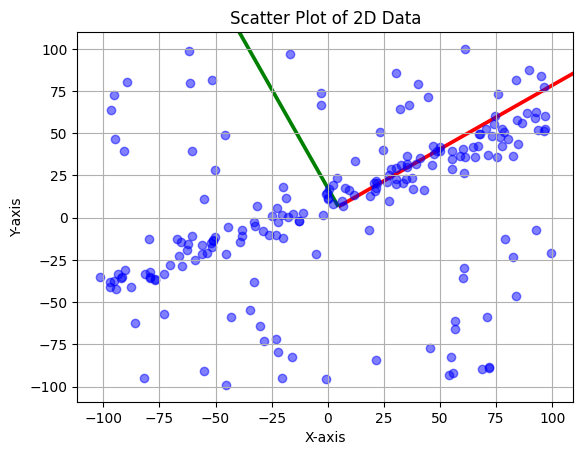

In [56]:
origin = np.array([mean, mean])  # Origin point for the vectors

plt.quiver([mean[0], mean[0]], [mean[1], mean[1]], scaled_eigenvectors[0], scaled_eigenvectors[1], color=['r', 'g'], scale = 1)

plt.scatter(data[0], data[1], c='blue', alpha=0.5)  # 'c' is the color, 'alpha' is transparency
plt.title('Scatter Plot of 2D Data')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.show()

## Find the optimal line ax + by = 𝑑 that fits the data in the total least square sense

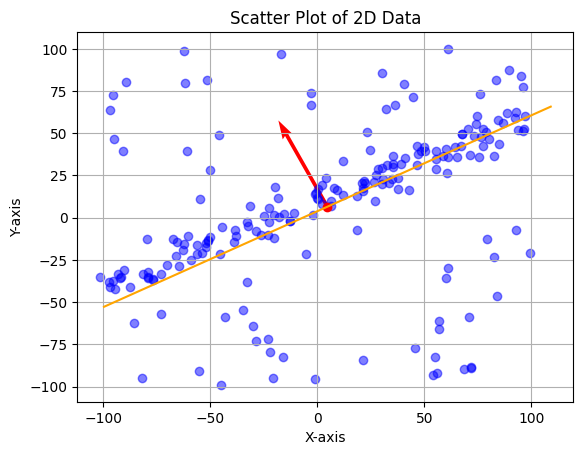

In [57]:
import numpy as np
import matplotlib.pyplot as plt

def plot_line(normal_vector, point_on_line):
    # Generate points along the line using the normal vector
    t = np.linspace(-120, 120, 10000)
    direction_vector = np.array([-normal_vector[1], normal_vector[0]])  # perpendicular direction
    line_points = np.outer(t, direction_vector) + point_on_line
    
    # Plot the line
    
    plt.quiver(point_on_line[0], point_on_line[1], normal_vector[0], normal_vector[1], color='red', scale=5, label='Normal Vector')
    
    plt.scatter(data[0], data[1], c='blue', alpha=0.5)  # 'c' is the color, 'alpha' is transparency
    plt.scatter(point_on_line[0], point_on_line[1], color='red', label='Point on Line')

    plt.plot(line_points[:, 0], line_points[:, 1], color='orange', label='Line')
    plt.title('Scatter Plot of 2D Data')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.grid(True)
    plt.show()

# Example inputs
normal_vector = np.array(eigenvectors[:, 1])  # Example normal vector (perpendicular to the line)
point_on_line = np.array(mean)  # Example point on the line

# Plot the line
plot_line(normal_vector, point_on_line)

# 3. Homography and Image Stitching 


## read and convert to gray

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read images
img1 = cv2.imread('image4.jpg')
img2 = cv2.imread('image5.jpg')
img3 = cv2.imread('image6.jpg')

# Resize images to 256x256
img1 = cv2.resize(img1, (256, 256))
img2 = cv2.resize(img2, (256, 256))
img3 = cv2.resize(img3, (256, 256))



## Functions for image stiching
- plot_figures()
- plot_all_matches()
- plot_match()

### Find Match using SIFT
- find_matches()

### RANSAC
- compute_homography_RANSAC()
- compute_homography_DLT()
- calculate_symmetric_transfer_error()
- find_inliner_matches()

### Warping
- combine_images()
- warp_right_image()


### image stiching
The function that executes all the functions above
- stich_right_image()

In [2]:
def plot_figures(gray1, gray2, gray3):
    # Plot
    fig = plt.figure()
    fig.set_figheight(12)
    fig.set_figwidth(12)

    plt.subplot(1, 3, 1)
    plt.imshow(gray1, cmap='gray')

    plt.subplot(1, 3, 2)
    plt.imshow(gray2, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.imshow(gray3, cmap='gray')


def plot_all_matches(img1, img2, img3, kp1, kp2, kp3, good_matches1_2, good_matches2_3):
    # Draw matches
    img_matches1_2 = cv2.drawMatches(img1, kp1, img2, kp2, good_matches1_2, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    img_matches2_3 = cv2.drawMatches(img2, kp2, img3, kp3, good_matches2_3, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Display matches
    fig = plt.figure()
    fig.set_figheight(12)
    fig.set_figwidth(12)

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img_matches1_2, cv2.COLOR_BGR2RGB))
    plt.title('Matches: Image 1 and Image 2')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img_matches2_3, cv2.COLOR_BGR2RGB))
    plt.title('Matches: Image 2 and Image 3')
    
def plot_match(img1, img2,kp1, kp2, good_matches1_2):
    # Draw matches
    img_matches1_2 = cv2.drawMatches(img1, kp1, img2, kp2, good_matches1_2, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Display matches
    fig = plt.figure()
    fig.set_figheight(12)
    fig.set_figwidth(12)

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img_matches1_2, cv2.COLOR_BGR2RGB))
    plt.title('Matches: Left image and right image')

## Find match using SIFT

In [3]:
def find_matches(gray1, gray2, gray3):
    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect keypoints and compute descriptors
    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)
    kp3, des3 = sift.detectAndCompute(gray3, None)

    # Feature matching
    bf = cv2.BFMatcher()

    # Match descriptors of adjacent images
    matches1_2 = bf.knnMatch(des1, des2, k=2)
    matches2_3 = bf.knnMatch(des2, des3, k=2)

    # Apply ratio test to find good matches
    good_matches1_2 = []
    for m, n in matches1_2:
        if m.distance < 0.75 * n.distance:
            good_matches1_2.append(m)

    good_matches2_3 = []
    for m, n in matches2_3:
        if m.distance < 0.75 * n.distance:
            good_matches2_3.append(m)
    
    return good_matches1_2, good_matches2_3, kp1, kp2, kp3

## RANSAC

In [4]:
def compute_homography_RANSAC(features_i, features_j, t=1.25, p=0.99):
    """
    Compute homography between two sets of corresponding features using RANSAC.

    Args:
    - features_i: List of features in image i
    - features_j: List of features in image j
    - t: Threshold for symmetric transfer error
    - p: Probability of all samples being free of outliers

    Returns:
    - H: Homography matrix
    """

    # Number of samples
    N = np.inf
    sample_count = 0

    # Number of features
    num_features = len(features_i)

    # Initialize best model
    best_inliers = 0
    best_H = None

    while N > sample_count:
        # Randomly sample four correspondences
        sample_indices = np.random.choice(num_features, 4, replace=False)
        sample_features_i = [features_i[idx] for idx in sample_indices]
        sample_features_j = [features_j[idx] for idx in sample_indices]

        # Compute homography using DLT
        H = compute_homography_DLT(sample_features_i, sample_features_j)

        # Calculate symmetric transfer error for all correspondences
        inliers = []
        for i in range(num_features):
            error = calculate_symmetric_transfer_error(features_i[i], features_j[i], H)
            if error < t:
                inliers.append(i)

        # Update best model if necessary
        if len(inliers) > best_inliers:
            best_inliers = len(inliers)
            best_H = H
            best_inliers_indices = inliers


        # Update N using adaptive determination method
        epsilon = 1 - (len(inliers) / num_features)
        if epsilon != 1:
            s = 4  # Number of correspondences for DLT
            N = np.log(1 - p) / np.log(1 - (1 - epsilon) ** s)

        sample_count += 1

    return best_H, best_inliers_indices

def compute_homography_DLT(features_i, features_j):
    """
    Compute homography using Direct Linear Transform (DLT) method.

    Args:
    - features_i: List of features in image i
    - features_j: List of features in image j

    Returns:
    - H: Homography matrix
    """

    A = []
    for i in range(len(features_i)):
        x_i, y_i = features_i[i]
        x_j, y_j = features_j[i]
        A.append([-x_i, -y_i, -1, 0, 0, 0, x_i * x_j, y_i * x_j, x_j])
        A.append([0, 0, 0, -x_i, -y_i, -1, x_i * y_j, y_i * y_j, y_j])

    A = np.array(A)
    _, _, V = np.linalg.svd(A)
    H = V[-1].reshape(3, 3)

    return H

def calculate_symmetric_transfer_error(point_i, point_j, H):
    """
    Calculate symmetric transfer error for a pair of corresponding points.

    Args:
    - point_i: Feature point in image i
    - point_j: Feature point in image j
    - H: Homography matrix

    Returns:
    - error: Symmetric transfer error
    """

    x_i, y_i = point_i
    x_j, y_j = point_j

    projected_i = H.dot(np.array([x_i, y_i, 1]))
    projected_j = np.linalg.inv(H).dot(np.array([x_j, y_j, 1]))

    error = np.linalg.norm(projected_i[:2] / projected_i[2] - np.array([x_j, y_j])) ** 2
    error += np.linalg.norm(projected_j[:2] / projected_j[2] - np.array([x_i, y_i])) ** 2

    return error



In [5]:
def find_inliner_matches(img1, img2, good_matches1_2, kp1, kp2):
    """
    Find inliner matches using RANSAC.

    Args:
    - img1, img2: images of left, right
    - good_matches1_2: matches of img1 and img2
    - kp1, kp2: Key points of img1, img2

    Returns:
    - H12: Homography matrix
    - inlier_matches1_2: List of inliner matches of img1 and img2
    """
    # Extract corresponding feature points
    features_i1 = np.float32([kp1[m.queryIdx].pt for m in good_matches1_2])
    features_j1 = np.float32([kp2[m.trainIdx].pt for m in good_matches1_2])
    
    # Compute homography using RANSAC
    H12, inliers_indices_12 = compute_homography_RANSAC(features_j1, features_i1)  
    
    # Filter inlier matches
    inlier_matches1_2 = [good_matches1_2[i] for i in inliers_indices_12]
    
    
    return H12, inlier_matches1_2

## Warping

In [6]:
def combine_images(image1, image2):
    return np.concatenate((image1, image2), axis=1)

def warp_right_image(left, right, H):
    output_size = (left.shape[1] + right.shape[1], left.shape[0])
    right_warped = cv2.warpPerspective(right, H, output_size, flags=cv2.INTER_LINEAR)
    right_warped[:, :int(output_size[0]/2), :] = left
    
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(right_warped, cv2.COLOR_BGR2RGB))
    plt.title('Warped Image: Image 2 + Image 3(warped)')
    plt.axis('off')
    plt.show()
    
    return right_warped
    

## Final function that executes all the functions above

In [7]:
def stich_right_image(img1, img2, img3):
    # Convert images to grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    gray3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)

    plot_figures(gray1, gray2, gray3)
    
    # Finding Matches using SIFT
    good_matches1_2, good_matches2_3, kp1, kp2, kp3 = find_matches(gray1, gray2, gray3)
    plot_all_matches(
        img1, img2, img3, 
        kp1, kp2, kp3, 
        good_matches1_2, good_matches2_3
    )
    
    # Inliners using RANSAC
    H12, inlier_matches1_2 = find_inliner_matches(
        img1, img2, 
        good_matches1_2,
        kp1, kp2,
    )
    H32, inlier_matches2_3 = find_inliner_matches(
        img2, img3, 
        good_matches2_3,
        kp2, kp3,
    )
    print("Homography H12:\n", H12)
    print("Homography H23:\n", H32)
    plot_all_matches(
        img1, img2, img3, 
        kp1, kp2, kp3, 
        inlier_matches1_2, inlier_matches2_3
    )
    
    # Warping
    right1 = warp_right_image(img2, img3, H32)
    
    return right1




## Left warping using right/left inversion
1. left/right inveresion img1
2. left/right inversion img2
3. Right warp inveresioned img1 and img2
4. finally, left/right inversion the warped image

Homography H12:
 [[-6.90271624e-03 -1.47777236e-04 -9.88432031e-01]
 [ 1.30585359e-03 -8.18748986e-03 -1.51018561e-01]
 [ 7.41054610e-06  5.98739673e-07 -8.89405144e-03]]
Homography H23:
 [[ 9.81614511e-03  3.14327730e-04  9.97375040e-01]
 [-1.39872785e-03  1.11207057e-02  6.98829093e-02]
 [-7.71409914e-06  3.33244558e-07  1.17186661e-02]]


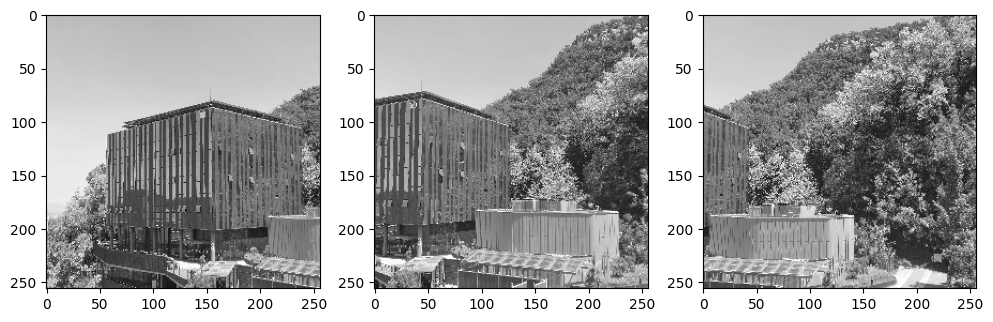

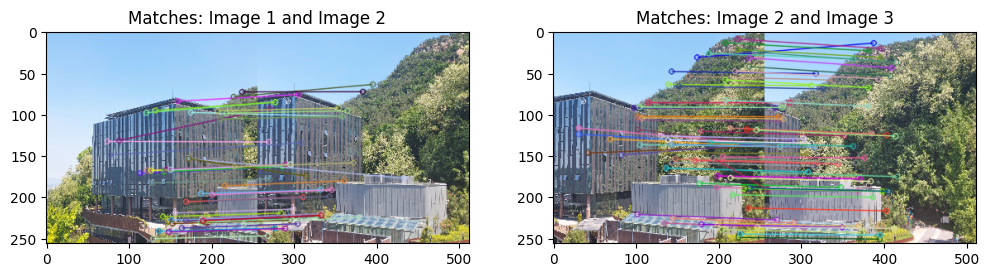

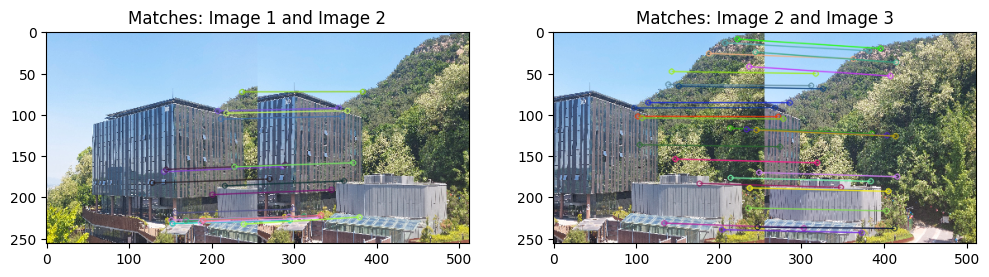

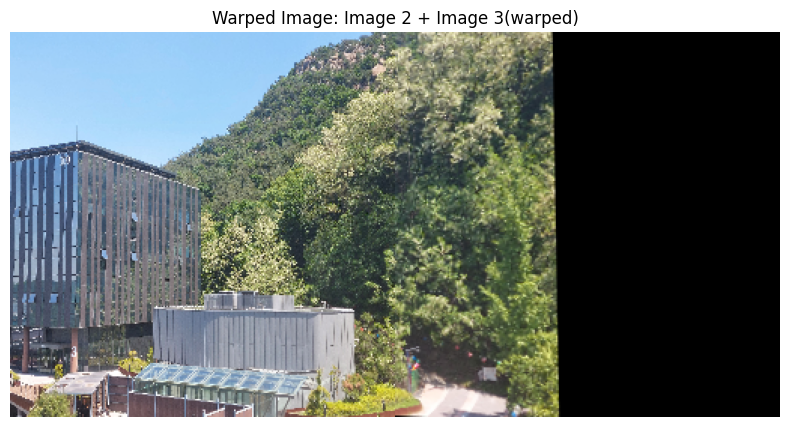

In [8]:
right1 = stich_right_image(img1, img2, img3)

Homography H12:
 [[ 9.17078269e-03  1.73394699e-04  9.84341179e-01]
 [-1.40703029e-03  1.05848348e-02  1.75344296e-01]
 [-7.92770442e-06 -2.02160056e-07  1.13432536e-02]]
Homography H23:
 [[-7.73422204e-03 -6.85439643e-04 -9.99518614e-01]
 [ 1.49953027e-03 -9.37610022e-03 -2.68563808e-02]
 [ 8.25201382e-06 -1.37565187e-06 -9.53027554e-03]]


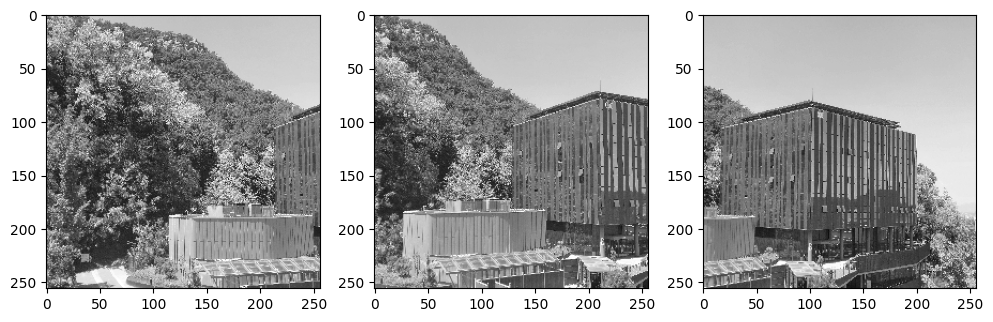

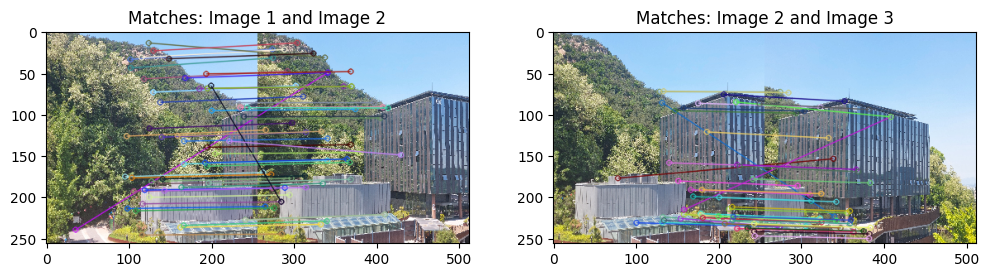

In [9]:
inversioned_img1 = np.fliplr(img1)
inversioned_img2 = np.fliplr(img2)
inversioned_img3 = np.fliplr(img3)

right2_inv = stich_right_image(inversioned_img3, inversioned_img2, inversioned_img1)

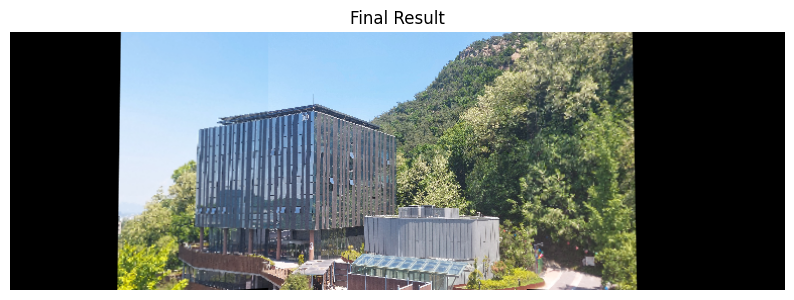

In [10]:
right2 = np.fliplr(right2_inv)

result = combine_images(right2, right1[:, 256:, :])

# plot
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title('Final Result')
plt.axis('off')
plt.show()